<center> 
<img src="https://upload.wikimedia.org/wikipedia/commons/5/5c/Logo_Mondragon_Unibertsitatea.png" width="150" height="100" float ="left">
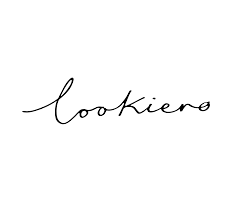    


---
<h3>Beñat Basabe, Jon Jarrín, June Pagaldai, Daniel Puente, Eneko Rentería | <font color='red'> Equipo Rojo<h3>

## Análisis inicial
En este script se detallarán los descriptivos obtenidos de este primer análisis. Tareas como detectar **cantidad de valores missing** o **outliers** entre otros.

### Carga de librerias 
---

- **General**

In [1]:
import pandas as pd
import numpy as np
import glob
import os

- **Pyspark**

In [2]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark import SparkFiles
from pyspark.sql import functions as F
import pyspark.sql.functions as f
from pyspark.sql.functions import lit, trim, split, regexp_replace, when

- **Strings**

In [3]:
from collections import Counter
import re

- **Visualización**

In [4]:
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns

* **Grafos**

In [5]:
import networkx as nx

- **Otros**

In [6]:
import itertools

### Clases a utilizar
---

* Clase para **cargar de datos** (cd)

Se fijan los **directorios** de entrada y salida

In [7]:
dir_in, dir_out = "../../datos/datos_originales/", "../../datos/datos_desarrollo/"

spark = SparkSession \
    .builder \
    .appName("how to read csv file") \
    .getOrCreate()

In [8]:
class carga_datos:
    ''' Cargar los datos desde el csv al python:
    - subir_tablas: se suben los dataframes con los titulos deseados. Como input: una lista de dfs y una lista de titulos.
    - subir_una_tabla: como input se especifica la tabla a subir.
    '''
    def __init__(self, dir_in = dir_in):
        self.dir_in = dir_in
        
    def subir_tablas(self, dir_in):
        path = os.getcwd()
        csv_files, dataframes_list = glob.glob(os.path.join(path, dir_in + "*.csv")), []

        for i in csv_files:
            temp_df = spark.read.csv(path = i, header = True, inferSchema = True)
            dataframes_list.append(temp_df)
        
        return dataframes_list
    
    def subir_una_tabla(self, dir_in, nombre_tabla):
        return pd.read_csv(os.path.join(dir_in, nombre_tabla + ".csv"))

In [9]:
cd = carga_datos ()

## Funciones a utilizar
---

- Función para **dar nombre** a la variable **family_id** mediante la variable title

In [10]:
def get_family_name(id_):
    
    filtered = product[product.family_id == id_]
    string = ' '.join(filtered.title).lower()
    
    return id_, Counter(string.split()).most_common(1)[0][0]

def get_family_name(id_):
    
    filtered = product.filter(product.family_id == id_)
    string = ' '.join([x['title'] for x in filtered.select('title').collect()]).lower()
    
    return id_, Counter(string.split()).most_common(1)[0][0]

- Función para crear los **sufijos** y facilitar el *join*

In [11]:
def rename_columns(df, suffix):
    ''' Renombra las columnas de un dataframe.'''
    for names in df.schema.names: df = df.withColumnRenamed(names,names + suffix)
    return df

* Función para conseguir valores únicos de una variable en *pyspark*

In [12]:
def get_value(dffs, variable):
    valores = [x[0] for x in dffs.select(variable).distinct().collect()]
    return valores

---

In [13]:
dfs = cd.subir_tablas(dir_in)
titulos = os.listdir(dir_in)

### Adecuar el *dataframe* size

In [14]:
size = cd.subir_una_tabla(dir_in, 'size')
size.to_csv(dir_out + 'size2.csv', sep = ';')
dfs[0] = spark.read.csv(path = dir_out + 'size2.csv', header = True, inferSchema = True, sep = ';')

### Unión de *dataframes*

<center> 
<img  src="../imagenes/diagrama.PNG"> 

#### 1) df_total =  product variant + color + size + season

- **Season**: No utilizar
- **Size**: Utilizar solo la talla creada por *lookiero*
- **Color**: Utilizar solo el nombre del color

product_variant + size = 116 not used sizes NAN  
product_variant_size + color = 1 not used color (mixt) NAN

* Renombrar con sufijos para facilitar el *join*

In [15]:
dfs[0] = rename_columns(dfs[0], '_size')
dfs[1] = rename_columns(dfs[1], '_color')

* Se junta los 2 dataframes en uno solo.

In [16]:
df_total = dfs[12].join(dfs[0].select('id_size','lookiero_size'), dfs[12].size_id == dfs[0].id_size, "inner").drop('id_size', 'size_id')
df_total = df_total.join(dfs[1].select('id_color', 'name_color'), df_total.color_id == dfs[1].id_color).drop('id_color', 'color_id', 'legacy_id', 'barcode')
df_total = df_total.withColumn("publishable", when(df_total.publishable == "f",False).when(df_total.publishable == "t",True))
df_total = df_total.withColumnRenamed("lookiero_size","size_lookiero") \
    .withColumnRenamed("name_color","color")

AttributeError: 'DataFrame' object has no attribute 'size_id'

* Se modifica la variable size_lookiero para que tenga formato legible

In [ ]:
df_total = df_total.withColumn('size_lookiero', split(df_total['size_lookiero'], ':').getItem(1))
df_total = df_total.withColumn('size_lookiero', regexp_replace('size_lookiero', '""', ''))
df_total = df_total.withColumn('size_lookiero', split(df_total['size_lookiero'], ',').getItem(0))
df_total = df_total.withColumn('size_lookiero', trim(f.col("size_lookiero")))

#### 2) df_total += product

product_variant + product = 41291 (63'3%) with no product_family or brand NAN

- **Product**: Dar nombre a la variable family_id y eliminar *legacy_id* y *channels*

* Crear las parejas

In [ ]:
product = dfs[7].drop('legacy_id', 'channels')

unique_values_family =  [x['family_id'] for x in product.select('family_id').distinct().collect()]
parejas = dict(map(get_family_name, unique_values_family))
product = product.withColumn("product_family", product["family_id"])

* Mapear las parejas creadas

In [ ]:
for k, v in enumerate(unique_values_family): 
    product = product.withColumn('product_family', regexp_replace('product_family', v, str(parejas[v])))

* Renombra la columna a la hora de unir

In [ ]:
product = product.drop('family_id', 'title', '"""group"""')
product = rename_columns(product, '_product')

df_total = df_total.join(product, df_total.product_id == product.id_product).drop('product_id')
df_total = df_total.withColumnRenamed("product_family_product","family_product")

#### 3) df_total += brand

- **brand**: No utilizar variable number

df_total + brand = 0 NAN

In [ ]:
brand = dfs[5].drop('number')
brand = brand.withColumnRenamed("id","id").withColumnRenamed("name","brand").withColumnRenamed("origin","brand_origin")
brand = rename_columns(brand, '_brand')
df_total = df_total.join(brand, df_total.brand_id_product == brand.id_brand).drop('brand_id_product','brand_id', 'id_brand')
df_total = df_total.withColumnRenamed("brand_brand", "name_brand").withColumnRenamed("brand_origin_brand", "origin_brand")

#### 4) values = feature values + feature (*value caracteristics*)

- **feature**: Multiple convertir en booleano (borrar??) y para poder eliminar la variable unit pasar los porcentajes a decimales (para diferenciarlos)

feature + feature_value = 1 value caracteristic not used NAN

In [ ]:
feature = dfs[6]
feature = feature.withColumn("multiple", when(feature.multiple == "f",False).when(feature.multiple == "t",True))
column_names = ['id', 'feature_name', 'feature_type', 'feature_multiple', 'unit']

for k, v in enumerate(column_names):  feature = feature.withColumnRenamed(feature.schema.names[k], v)
feature_value = dfs[4]
feature = rename_columns(feature, '_values')
values = feature_value.join(feature, feature_value.feature_id == feature.id_values).drop('feature_id','id_values', 'feature_type_values', 'unit_values')

### **Hay que corregirlo pero no sé cómo**	

feature_family no sirve para nada **creo** por lo que las siguientes celda en raw

#### 5) values + value family

In [ ]:
for k, v in enumerate(['feature_family', 'feature_value_id']):  dfs[11] = dfs[11].withColumnRenamed(dfs[11].schema.names[k], v)
values = values.join(dfs[11], values.id == dfs[11].feature_value_id).drop('feature_value_id')

#### 6) product_values = values + product_feature_value

values + product_feature_value = 1420 (1'84%) caracteristics that has no product NAN

In [ ]:
values = values.withColumnRenamed('id', 'id_values')
dfs[9] = dfs[9].withColumnRenamed('id', 'id_product_feature')
product_values = values.join(dfs[9], values.id_values == dfs[9].feature_value_id).drop('feature_value_id')

#### 7) product_values + df_total

products + features = 383 (0'06%) products without caracteristics NAN

In [ ]:
df = df_total.join(product_values, df_total.id_product == product_values.product_id).drop('product_id')

* Adecuar variables para la comprensión

In [ ]:
df = df.drop('id_values', 'multiple_values')
df = df.withColumnRenamed('feature_multiple_values', 'multiple_values').withColumnRenamed('feature_name_values','name_feature')
df = df.withColumn('id_product', f.concat(f.col('family_product'), lit('_'), f.col('color') , lit('_'), f.col('size_lookiero')))
df = df.withColumn('id_product_feature', f.concat(f.col('name_feature'), lit('_'), f.col('value')))

- id = Un único producto (se repite pork tiene diferentes features)  
- id_product = El producto en general (niki manga larga)  
- id_values = id de una característica (**borrado**)     
- id_product_feature = id de la característica de un producto en general (id_product)(**borrado**)

### Relaciones
---

* Crear variables para verificar reglas

In [ ]:
niveles = {'jumpsuit': '1.1', 
           'dress': '1.1',
           
           'jeans': '1.2',
           'skirt': '1.2',
           'short': '1.2',
           'pant': '1.2',
          
           'shirt': '2.1',
           'top': '2.1',
           'tshirt': '2.1',
          
           'sweater': '2.2',
           'sweatshirt': '2.2',
           'cardigan': '2.2',
          
           'trench': '3.1',
           'coat': '3.1',
           'parka': '3.1',
           'jacket': '3.1',
          
           'bag': '3.2',
           'scarf': '3.2'}

df = df.withColumn('level', df['family_product'])
df = df.replace(niveles, 'level')

**COMBINACIONES NO POSIBLES:**
- 1.2 + 3.2 + 3.2 (*falta parte de arriba*)
- 2.1 + 2.1 (*demasiados nikis*)
- 2.2 + 2.2 (*demasiados jerses*)
- 3.1 + 3.1 (*demasiadas txammaras*)

* Ponderaciones de relaciones

### Grafo
---

#### 1) Nodos *(está solo con 10)*

- Crear el grafo y los productos 

In [ ]:
G = nx.Graph()
vu_id_product, vu_id = get_value(df, 'id_product'), get_value(df, 'id')

* Añadir los productos con su color y size en el grafo

In [ ]:
for k, v in enumerate(vu_id_product[:10]):
    G.add_nodes_from([(k, {"color": get_value(df.filter(df.id_product == v), 'color')[0]})])
    G.add_nodes_from([(k, {"size":  get_value(df.filter(df.id_product == v), 'size_lookiero')[0]})])

* Relación de número (id) con producto

In [ ]:
df_para_filtrar = pd.DataFrame(vu_id_product).reset_index()
df_para_filtrar['family_product'] = pd.Series([e[0] for e in df_para_filtrar[0].str.split('_')])
df_para_filtrar['level'] = df_para_filtrar.family_product.map(niveles)

#### 2) Aristas

**Aristas: Temporada** (*está para 10 combinaciones*)

In [ ]:
combinaciones_temporada = []

for i in [7,8,9]:
    filtrado = df.filter(df.id_product.isin(valores_unicos_id_product[:10]))
    filtrado  = filtrado.filter(filtrado.season == i).select('id_product')
    valores = get_value(filtrado, 'id_product')
    indeces_estaciones = df_para_filtrar[df_para_filtrar[0].isin(valores)].index.tolist()
    combinaciones = list(itertools.combinations(indeces_estaciones, 2))
    combinaciones_temporada += combinaciones

**Aristas: Level** (*está para todas las combinaciones*)

- Crear combinaciones (aristas)

In [ ]:
levels = get_value(df.filter(df.id_product.isin(vu_id_product)), 'level')
levels.sort()
tods = list(itertools.combinations(levels, 2))
tods.sort()

* Cambios necesarios para que cumplan las reglas definidas

In [ ]:
tods += [('3.2', '3.2')]
tods.remove(('1.1', '1.2'))

* Traducir de combinaciones de *levels* a los ids de los nodos

In [ ]:
combinaciones_level = []

for e in tods:
    
    list_1 = df_para_filtrar[df_para_filtrar.level == e[0]].index.to_list()
    list_2 = df_para_filtrar[df_para_filtrar.level == e[1]].index.to_list()

    combinaciones_level += list(itertools.product(list_1, list_2))

**Aristas: Tallas**

In [ ]:
combinaciones_talla

**Aristas: Completo**

* En caso de que solo tenga que cumplir 1:

In [ ]:
aristas = list(set(combinaciones_level + combinaciones_temporada + combinaciones_talla))

* En caso de que tenga que cumplir todos:

In [ ]:
aristas = list(set(set(combinaciones_level).intersection(combinaciones_temporada)).intersetcion(combinaciones_talla))

In [ ]:
G.add_edges_from(aristas)

**Plotear grafo**

In [ ]:
nx.draw(G, with_labels = True)

### Gráficos
---

In [ ]:
def human_format(num):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '%.2f%s' % (num, ['', 'K', 'M', 'B', 'T', 'P'][magnitude])

paleta = ['#264653','#2A9D8F','#85CAC2','#DFF6F4' ,'#E9C46A','#F4A261','#E76F51','#C53D1B', '#7E2711']

#### Estaciones

In [ ]:
season_collection = dfs[2].select('season').collect()
season = np.array([x[0] for x in season_collection])
count_values = np.bincount(season)[-3:]

fig = go.Figure(data=[go.Bar( x=count_values, y=['7', '8', '9'],text=count_values,textposition='auto',texttemplate = [human_format(a) for a in count_values],orientation='h')])
fig.update_traces(marker_color=[paleta[0], paleta[1], paleta[0]],marker_line_width=1, opacity=0.8, marker_line_color = 'black')

fig.update_layout(
    title='Estaciones más frecuente Lookiero',
    xaxis_title = 'Cantidad',
    yaxis_title = 'Estaciones', 
    # width=2280, height=950, font = dict(size = 22),
    paper_bgcolor='white',
    plot_bgcolor='white', 
    xaxis_range=[20000,23000]
)

#### Familias de producto

In [ ]:
product_family = df_total.select('family_product').collect()
product_family = np.array([x[0] for x in product_family])
unique_elements, counts_elements = np.unique(product_family, return_counts=True)
counts_elements, unique_elements = (zip(*reversed(sorted(zip(counts_elements, unique_elements)))))

In [ ]:
colores = [paleta[1]] * 3 + [paleta[0]] * (len(counts_elements) - 9) + [paleta[6]] * 6
fig = go.Figure(data=[go.Bar( x=unique_elements, y=counts_elements,text=count_values,textposition='auto',texttemplate = [human_format(a) for a in counts_elements], orientation='v')])
fig.update_traces(marker_color=colores,marker_line_width=1, opacity=0.8, marker_line_color = 'black')

fig.update_layout(
    title='Productos más populares',
    xaxis_title = 'Productos',
    yaxis_title = 'Cantidad',
    # width=2280, height=950, font = dict(size = 22),
    paper_bgcolor='white',
    plot_bgcolor='white')


#### Size percentaje

In [ ]:
size_lookiero = df_total.select('size_lookiero').collect()
size_lookiero = np.array([x[0] for x in size_lookiero])

unique_elements, counts_elements = np.unique(size_lookiero, return_counts=True)
counts_elements, unique_elements = (zip(*reversed(sorted(zip(counts_elements, unique_elements)))))
counts_elements, unique_elements = np.array(counts_elements), np.array(unique_elements)
counts_elements = (counts_elements / counts_elements.sum()) * 100

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

labels = unique_elements


fig = make_subplots(rows = 1, cols = 2, specs = [[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels = labels, values = counts_elements, marker_colors = paleta), 1, 1)

fig.update_traces(hole = .6, hoverinfo = "label + percent + name")

fig.update_layout(
    title_text="Cantidad de productos por tamaño",
    font = dict(size = 12),
    annotations = [dict(text = 'Tallas', x = 0.20, y = 0.5, 
    font_size = 16, showarrow = False
    )])
fig.show()

#### Tallas - Productos


In [ ]:
tallas = df_total.select('size_lookiero').collect()
tallas = np.array([x[0] for x in tallas])
df_heat = pd.DataFrame()
df_heat['size'], df_heat['product_family'] = tallas, product_family

hm_131_p = pd.get_dummies(df_heat, columns=['product_family']).groupby(['size']).sum()
hm_131_p.columns = [x.replace('product_family_', '').capitalize() for x in hm_131_p.columns]

In [ ]:
fig3, ax3 = plt.subplots(figsize = (25,5))
ax3 = sns.heatmap(hm_131_p, cmap = 'bone')
ax3.set_ylabel('Tallas')
ax3.set_xlabel('Productos')
ax3.set_title("Relación entre tallas y productos", fontweight = 'bold');

#### Empresas con mayor stock

In [ ]:
empresas = df_total.select('name_brand').collect()
empresas = np.array([x[0] for x in empresas])
stock = np.array([x[0] for x in df_total.select('stock').collect()])

In [ ]:
df_empresas_stock = pd.DataFrame()
df_empresas_stock['empresas'], df_empresas_stock['stock'] = empresas, stock
top_10_empresas = df_empresas_stock.groupby('empresas').agg({'stock':'sum'}).sort_values(by='stock', ascending=False).head(10).reset_index()
valores = df_empresas_stock.groupby('empresas').agg({'stock':'sum'}).sort_values(by='stock', ascending=False).head(10)
errors = df_empresas_stock.groupby('empresas').agg({'stock':'std'}).sort_values(by='stock', ascending=False).head(10)

In [ ]:
fig, ax = plt.subplots(figsize = (25,5))

ax.bar(valores.index, valores.stock, yerr=errors.stock, align='center', alpha=0.8, ecolor='black', capsize=10, color = paleta[0])
ax.set_facecolor('white')
plt.title('Top 10 empresas con mayor stock', fontweight='bold')
plt.xlabel('Empresas')
plt.ylabel('Stock')
plt.show()

Viendo que muchas empresas no se puede ver el stock que tiene, se decide generar otro gráfico para ver más en detalle el stock de esas empresas.

In [ ]:
fig, ax = plt.subplots(figsize = (25,5))

ax.bar(valores.index[3:], valores.stock[3:], yerr=errors.stock[3:], align='center', alpha=0.8, ecolor='black', capsize=10, color = paleta[0])
ax.set_facecolor('white')
plt.title('7 de las empresas con mayor stock', fontweight='bold')
plt.xlabel('Empresas')
plt.ylabel('Stock')
plt.show()

#### Productos más vendidos y origin

In [ ]:
product_family = df_total.select('family_product').collect()
product_family = np.array([x[0] for x in product_family])
unique_elements, counts_elements = np.unique(product_family, return_counts=True)
counts_elements, unique_elements = (zip(*reversed(sorted(zip(counts_elements, unique_elements)))))

In [ ]:
product_family_product, brand_origin_brand = np.array([x[0] for x in df_total.select('family_product').collect()]), np.array([x[0] for x in df_total.select('origin_brand').collect()])
df_product_family_product = pd.DataFrame()
df_product_family_product['family_product'], df_product_family_product['origin_brand'] = product_family_product, brand_origin_brand
df_product_family_product = df_product_family_product[df_product_family_product['family_product'].isin(unique_elements[:5])].reset_index(drop = True)

In [ ]:
dumificado = pd.get_dummies(df_product_family_product, columns=['family_product']).groupby(['origin_brand']).sum().reset_index()
dumificado.columns = [dumificado.columns[0]] + [x.replace('family_product_', '').capitalize() for x in dumificado.columns[1:]]
for x in range(len(dumificado)): 
    dumificado.iloc[x, 1:] = (dumificado.iloc[x, 1:] / dumificado.iloc[x, 1:].sum() * 100)
    dumificado.iloc[x, 1:] = dumificado.iloc[x,1:].apply(lambda x: x.round(1))

In [ ]:
from itertools import cycle

x_data = dumificado.iloc[:, 1:].values

import plotly.graph_objects as go


top_labels = dumificado.columns[1:]
colors = np.array(paleta)[[0, 1, 2, 4, 5]]
y_data = dumificado.iloc[:,0].values

fig = go.Figure()

for i in range(0, len(x_data[0])):
    for xd, yd in zip(x_data, y_data):
        fig.add_trace(go.Bar(
            x=[xd[i]], y=[yd],orientation='h',marker=dict(color=colors[i],line=dict(color='rgb(248, 248, 249)', width=1))))

fig.update_layout(
    title='Productos más populares y su influencia en el mercado',
    xaxis=dict(
        showgrid=False,showline=False,showticklabels=False,zeroline=False,domain=[0.15, 1]),

    yaxis=dict(
        showgrid=False,showline=False,showticklabels=False,zeroline=False,),
#     width=2280, height=850, font = dict(size = 22),
    barmode='stack',paper_bgcolor='white',plot_bgcolor='white',margin=dict(l=120, r=10, t=140, b=80),showlegend=False,)

annotations = []

for yd, xd in zip(y_data, x_data):

    annotations.append(dict(xref='paper', yref='y',
                            x=0.14, y=yd,xanchor='right',text=str(yd),font=dict(family='Arial', size=12,color='rgb(67, 67, 67)'),showarrow=False, align='right'))

    annotations.append(dict(xref='x', yref='y',
                            x=xd[0] / 2, y=yd,text=str(xd[0]) + '%',font=dict(family='Arial', size=12,color='rgb(248, 248, 255)'),showarrow=False))

    if yd == y_data[-1]:
        annotations.append(dict(xref='x', yref='paper',
                                x=xd[0] / 2, y=1.1,text=top_labels[0],font=dict(family='Arial', size=12,color='rgb(67, 67, 67)'),showarrow=False))
                                
    space = xd[0]
    for i in range(1, len(xd)):
            annotations.append(dict(xref='x', yref='y',
                                    x=space + (xd[i]/2), y=yd,text=str(xd[i]) + '%',font=dict(family='Arial', size=12,color='rgb(248, 248, 255)'),showarrow=False))
            if yd == y_data[-1]:
                annotations.append(dict(xref='x', yref='paper',
                                        x=space + (xd[i]/2), y=1.1,text=top_labels[i],font=dict(family='Arial', size=12,color='rgb(67, 67, 67)'),showarrow=False)) #, textangle=90
            space += xd[i]

fig.update_layout(annotations=annotations)
fig.show()

#### Puntos

In [ ]:
product_family = np.array([x[0] for x in df_total.select('family_product').collect()])
unique_elements, counts_elements = np.unique(product_family, return_counts=True)
counts_elements, unique_elements = (zip(*reversed(sorted(zip(counts_elements, unique_elements)))))

color, product_family_product = np.array([x[0] for x in df_total.select('color').collect()]), np.array([x[0] for x in df_total.select('family_product').collect()])
df_color = pd.DataFrame()
df_color['color'], df_color['family_product'] = color, product_family_product

dumificado = pd.get_dummies(df_color, columns=['family_product']).groupby(['color']).sum().reset_index()
dumificado.columns = [dumificado.columns[0]] + [x.replace('family_product_', '') for x in dumificado.columns[1:]]
dumificado['total'] = dumificado.iloc[:,1:].sum(axis=1)

dumificado = dumificado.loc[:,['color','total'] + list(unique_elements[:3])]

In [ ]:
g = sns.PairGrid(dumificado.sort_values("total", ascending=False),
                 x_vars=dumificado.columns[-4:], y_vars=["color"],
                 height=10, aspect=.25)

g.map(sns.stripplot, size=10, orient="h", jitter=False,
      palette="mako", linewidth=1, edgecolor="w")

g.set(xlabel="Cuantity", ylabel="")
titles = [x.capitalize() for x in dumificado.columns[-4:]]

for ax, title in zip(g.axes.flat, titles):
    ax.set(title=title)
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

#### Publicados por origen de marca (Spider)

In [ ]:
publishable = np.array([x[0] for x in df_total.select('publishable').collect()])
stock = np.array([x[0] for x in df_total.select('stock').collect()])

In [ ]:
df_empresas_spider = pd.DataFrame()
df_empresas_spider['publishable'], df_empresas_spider['stock'], df_empresas_spider['brand_origin_brand'] = publishable, stock, brand_origin_brand
df_empresas_spider = df_empresas_spider.pivot_table(index = 'publishable', columns='brand_origin_brand', values = 'stock', aggfunc ='sum')
df_empresas_spider.reset_index(drop = True, inplace = True)

df_empresas_spider = ((df_empresas_spider.T / df_empresas_spider.sum(axis = 1))*100).T
df_empresas_spider = pd.concat([pd.Series(['No Published', 'Published']), df_empresas_spider], axis = 1).rename({0: 'group'}, axis = 1)

In [ ]:
from math import pi

df_empresas_spider['group'] = df_empresas_spider['group'].astype('str')
categories = list(df_empresas_spider)[1:]
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
ax = plt.subplot(111, polar=True)
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
plt.xticks(angles[:-1], categories)
ax.set_rlabel_position(0)
plt.yticks([0.12,0.2,0.28], ["10","20","30"], color="grey", size=7)

 
color_list = ['darkblue', 'darkred', 'darkgreen']

for i in range(len(df_empresas_spider)):
    
    values = df_empresas_spider.loc[i].drop('group').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth = 1, linestyle='solid', label = df_empresas_spider.group[i], color = color_list[i])
    ax.fill(angles, values, color = color_list[i], alpha = 0.15)
    
plt.legend(loc = 'upper right', bbox_to_anchor = (0.1, 0.1))
plt.title('Porcentaje dedicado a cada origen de marca de los publicados y no publicados')
plt.show()

#### Productos que más suelen estar en stock

In [ ]:
product_family

In [ ]:
stock

In [ ]:
print('% de valores nulos en stock:', len(stock[stock == 0])/len(stock) * 100)